In [80]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from warnings import simplefilter # disable tensorflow warnings
simplefilter(action='ignore', category=FutureWarning)

import h5py
import imageio
import ipdb
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial.transform import Rotation as R
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from robonet.robonet.datasets.util.hdf5_loader import (default_loader_hparams,
                                                       load_actions,
                                                       load_camera_imgs,
                                                       load_qpos, load_states)
from robonet.robonet.datasets.util.metadata_helper import load_metadata
from src.env.robotics.masks.baxter_mask_env import BaxterMaskEnv
from src.env.robotics.masks.sawyer_mask_env import SawyerMaskEnv
from src.env.robotics.masks.widowx_mask_env import WidowXMaskEnv
from tqdm.notebook import tqdm

robonet_root = "/media/ed/hdd/Datasets/Robonet/hdf5/"
metadata_path = "/media/ed/hdd/Datasets/Robonet/hdf5/meta_data.pkl"

In [3]:
def load_all_states(hdf5_list):
    all_states = []
    prev_ws_min = prev_ws_max = None
    
    for traj_name in tqdm(hdf5_list, f"Collecting states"):
        file_metadata = df.loc[traj_name]
        ws_min = file_metadata["low_bound"]
        ws_max = file_metadata["high_bound"]
        if prev_ws_min is None:
            prev_ws_min = ws_min
            prev_ws_max = ws_max
        ws_min_close = np.allclose(prev_ws_min, ws_min)
        ws_max_close = np.allclose(prev_ws_max, ws_max)
        if not (ws_min_close and ws_max_close):
            print(traj_name, "ws not same")
            print(ws_min, prev_ws_min)
            print(ws_max, prev_ws_max)
        prev_ws_min = ws_min
        prev_ws_max = ws_max
        
        
        f_name = os.path.join(robonet_root, traj_name)

        with h5py.File(f_name, "r") as hf:
            start_time, n_states = 0, min([file_metadata['state_T'], file_metadata['img_T'], file_metadata['action_T'] + 1])
            states = load_states(hf, file_metadata, hparams)
            assert states.shape[-1] == 5
            all_states.append(states)
    return np.asarray(all_states), ws_min, ws_max

In [11]:
# first load widowx states
hparams = tf.contrib.training.HParams(**default_loader_hparams())
hparams.img_size = [120, 160]
hparams.cams_to_load = [0]

df = pd.read_pickle(metadata_path, compression="gzip")
widowx_df = df.loc["widowx" == df["robot"]]
widowx_subset = widowx_df[widowx_df["camera_configuration"] == "widowx1"].sample(100)
widowx_states, widowx_min, widowx_max = load_all_states(widowx_subset.index)

sawyer_df = df.loc["sawyer" == df["robot"]]
sawyer_subset = sawyer_df["sudri0" == sawyer_df["camera_configuration"]].sample(100)
sawyer_states, sawyer_min, sawyer_max = load_all_states(sawyer_subset.index)

baxter_df = df.loc["baxter" == df["robot"]]
left = ["left" in x for x in baxter_df.index]
right = [not x for x in left]
baxter_left_subset = baxter_df[left].sample(100)
baxter_right_subset = baxter_df[right].sample(100)
baxter_left_states, baxter_left_min, baxter_left_max = load_all_states(baxter_left_subset.index)
baxter_right_states, baxter_right_min, baxter_right_max = load_all_states(baxter_right_subset.index)

In [9]:
robot_data = {"baxter_left": baxter_left_states, "baxter_right": baxter_right_states, "sawyer": sawyer_states, "widowx": widowx_states}
robot_min = {"baxter_left": baxter_left_min, "baxter_right": baxter_right_min, "sawyer": sawyer_min, "widowx": widowx_min}
robot_max = {"baxter_left": baxter_left_max, "baxter_right": baxter_right_max, "sawyer": sawyer_max, "widowx": widowx_max}


# Rotation bounds
They are stored in raw radians. I don't think I need to normalize the gripper rotations since they are all in radians already.

Seems like gripper rotations need to be normalized with radians. Baxter's gripper rotation bounds are in degree
 

Examining rotation
baxter_left Raw Data stats


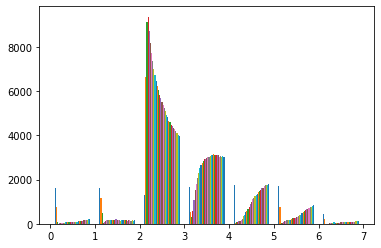

min 0.00 max 6.28 mean 3.06
baxter_right Raw Data stats


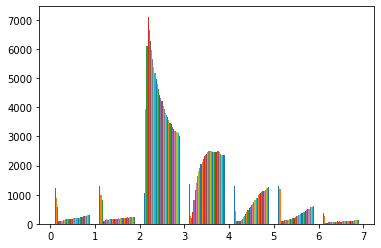

min 0.00 max 6.28 mean 3.02
sawyer Raw Data stats


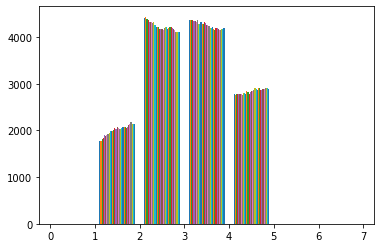

min 1.50 max 4.68 mean 3.10
widowx Raw Data stats


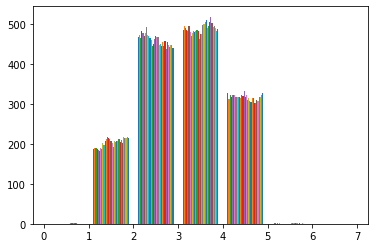

min 0.42 max 5.23 mean 3.14


In [76]:
# examine gripper rotation for each robot
print("Examining rotation")
# fig, axes = plt.subplots(1, len(robot_data.keys()))
for robot, states in robot_data.items(): 
    gripper_rotation = states[:,:, 3]
    print(f"{robot} Raw Data stats")
    plt.hist(gripper_rotation, bins=[0,1,2,3,4,5,6,7])
    plt.show()
    print(f"min {gripper_rotation.min():.2f}", f"max {gripper_rotation.max():.2f}", f"mean {gripper_rotation.mean():.2f}")
#     rmin = robot_min[robot][3]
#     rmax = robot_max[robot][3]
#     if "baxter" in robot:
#         # convert to radians
#         rmin *= np.pi/180
#         rmax *= np.pi/180
#     print("rotation min, rotation max", rmin, rmax)
#     print(f"After Normalization stats")
#     gripper_rotation_norm = (states[:,:, 3] -  rmin) / (rmax - rmin)
#     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
# #     print(f"After Denormalization stats")
# #     gripper_rotation_norm = (states[:,:, 3] * (rmax - rmin)) + rmin
# #     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
#     print()



# Force Bounds
Stored in raw gripper qpos, needs to be normalized to[0,1)

Examining force
baxter_left Raw Data stats
min 1.77 max 100.00 mean 48.67
rotation min, rotation max 0.0 100.0
After Normalization stats
min 0.02 max 1.00 mean 0.49



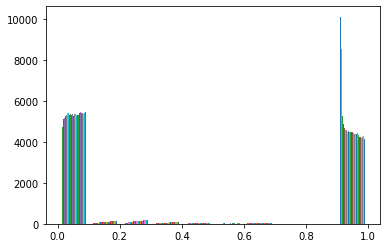

baxter_right Raw Data stats
min 2.92 max 100.00 mean 50.28
rotation min, rotation max 0.0 100.0
After Normalization stats
min 0.03 max 1.00 mean 0.50



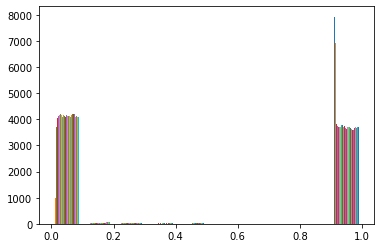

sawyer Raw Data stats
min -1.01 max 1.02 mean -0.01
rotation min, rotation max -1.0 1.0
After Normalization stats
min -0.00 max 1.01 mean 0.49



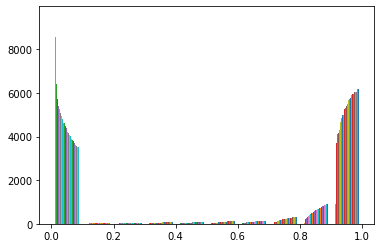

widowx Raw Data stats
min -1.01 max 1.01 mean 0.29
rotation min, rotation max -1.0 1.0
After Normalization stats
min -0.01 max 1.00 mean 0.65



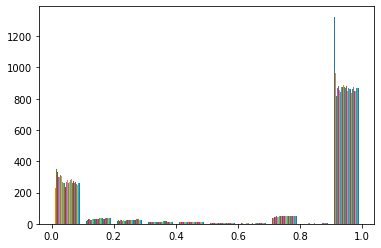

In [78]:
# examine gripper force for each robot
print("Examining force")
for robot, states in robot_data.items(): 
    gripper_rotation = states[:,:, 4]
    print(f"{robot} Raw Data stats")
    print(f"min {gripper_rotation.min():.2f}", f"max {gripper_rotation.max():.2f}", f"mean {gripper_rotation.mean():.2f}")
    rmin = robot_min[robot][4]
    rmax = robot_max[robot][4]
#     if "baxter" in robot:
#         # convert to radians
#         rmin *= np.pi/180
#         rmax *= np.pi/180
    print("rotation min, rotation max", rmin, rmax)
    print(f"After Normalization stats")
    gripper_rotation_norm = (states[:,:, 4] -  rmin) / (rmax - rmin)
    print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
#     print(f"After Denormalization stats")
#     gripper_rotation_norm = (states[:,:, 3] * (rmax - rmin)) + rmin
#     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
    print()
    plt.hist(gripper_rotation_norm, bins=[0.1 * x for x in range(0, 11)])
    plt.show()

# XYZ Bounds
Let's double check that the XYZ positions are normalized per robot already.

Examining X
baxter_left Raw Data stats


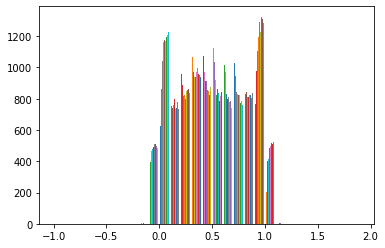

min -0.20 max 1.16 mean 0.50
rotation min, rotation max 0.15 0.59

baxter_right Raw Data stats


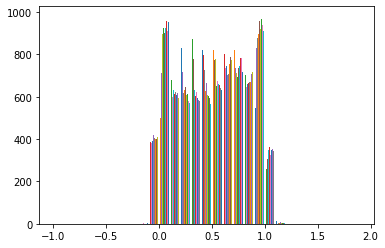

min -0.19 max 1.20 mean 0.51
rotation min, rotation max -0.63 -0.2

sawyer Raw Data stats


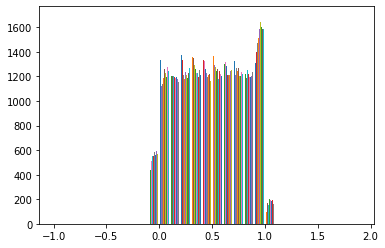

min -0.03 max 1.02 mean 0.50
rotation min, rotation max -0.18 0.22

widowx Raw Data stats


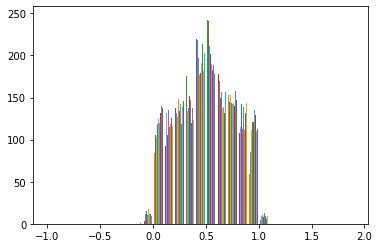

min -0.12 max 1.07 mean 0.50
rotation min, rotation max -0.13 0.13



In [95]:
# examine X  for each robot
print("Examining X")
# fig, axes = plt.subplots(1, len(robot_data.keys()))
for robot, states in robot_data.items(): 
    axis = 1
    gripper_rotation = states[:,:, axis]
    print(f"{robot} Raw Data stats")
    plt.hist(gripper_rotation, bins=[0.1 * x for x in range(-10, 20)])
    plt.show()
    print(f"min {gripper_rotation.min():.2f}", f"max {gripper_rotation.max():.2f}", f"mean {gripper_rotation.mean():.2f}")
    rmin = robot_min[robot][axis]
    rmax = robot_max[robot][axis]
#     if "baxter" in robot:
        # convert to radians
#         rmin *= np.pi/180
#         rmax *= np.pi/180
    print("rotation min, rotation max", rmin, rmax)
#     print(f"After Normalization stats")
#     gripper_rotation_norm = (states[:,:, 3] -  rmin) / (rmax - rmin)
#     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
# #     print(f"After Denormalization stats")
# #     gripper_rotation_norm = (states[:,:, 3] * (rmax - rmin)) + rmin
# #     print(f"min {gripper_rotation_norm.min():.2f}", f"max {gripper_rotation_norm.max():.2f}", f"mean {gripper_rotation_norm.mean():.2f}")
    print()



# Action Bounds

In [33]:
def load_all_actions(hdf5_list):
    all_actions = []
    
    for traj_name in tqdm(hdf5_list, f"Collecting actions"):
        file_metadata = df.loc[traj_name]
        f_name = os.path.join(robonet_root, traj_name)

        with h5py.File(f_name, "r") as hf:
            actions = load_actions(hf, file_metadata, hparams)
            assert actions.shape[-1] == 4, actions.shape
            all_actions.append(actions)
    return np.asarray(all_actions)

In [35]:
widowx_actions = load_all_actions(widowx_subset.index)
baxter_left_actions = load_all_actions(baxter_left_subset.index)
baxter_right_actions = load_all_actions(baxter_right_subset.index)
sawyer_actions = load_all_actions(sawyer_subset.index)

In [36]:
action_data = {"baxter_left": baxter_left_actions, "baxter_right": baxter_right_actions, "sawyer": sawyer_actions, "widowx": widowx_actions}


In [91]:
np.set_printoptions(8, suppress=True)
for robot in ["sawyer"]:
    all_actions = action_data[robot]
    all_states = robot_data[robot]
    low = robot_min[robot][:4]
    high = robot_max[robot][:4]
    diffs = []
    for state_trajectory, action_trajectory in zip(all_states, all_actions):
        # first denormalize the state trajectory
        state_trajectory = state_trajectory[:, :4]
        state_trajectory = state_trajectory * (high - low)
        state_trajectory = state_trajectory + low
        
        # denormalize the action trajectory
        action_trajectory = action_trajectory[:, :4]
#         action_trajectory = action_trajectory * (high - low)
#         action_trajectory = action_trajectory + low
        
        
#         for i, action in enumerate(action_trajectory):
#             curr_state = state_trajectory[i]
#             next_state = state_trajectory[i+1]
#             pred_state = curr_state + action
#             print(curr_state)
#             print(action)
#             print(pred_state)
#             print(next_state)
            
#             print("calculating percent error")
#             true_displacement = next_state - curr_state
#             diff = np.abs(true_displacement - action)
#             print(diff)
#             print(true_displacement)
#             percent_off = 100 * diff / true_displacement
#             print(percent_off)
#             print()
#             break
                  
#         break
#         true_actions = state_trajectory[1:] - state_trajectory[:-1]
#         diff = np.abs(action_trajectory - true_actions)
#         percent_off = np.abs((diff / true_actions) * 100)
#         percent_off = np.mean(percent_off, axis=0)
#         diffs.append(percent_off)

            
        shifted_states = state_trajectory[:-1] + action_trajectory
        next_states = state_trajectory[1:]
        diff = np.abs(shifted_states - next_states)
        diff = np.mean(diff, axis=0)
        diffs.append(diff)
#         assert np.allclose(shifted_states, next_states)

In [92]:
diffs = np.asarray(diffs)
diffs.mean(axis=0)

array([0.03660304, 0.03749607, 0.07251998, 0.41875075])

# Convert Action to Camera Space

In [108]:
actions = action_data["sawyer"]
states = robot_data["sawyer"]
w_to_c = np.array(
        [
            [-0.01290487, 0.62117762, -0.78356355, 1.21061856],
            [1, 0.00660994, -0.01122798, 0.01680913],
            [-0.00179526, -0.78364193, -0.62121019, 0.47401633],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )

def convert_to_camera_space(state, w_to_c):
    e_to_w = np.eye(4)
    # compute rotation matrix of end effector
    # http://planning.cs.uiuc.edu/node102.html
    a = state[3]
    b = 0
    g = 0
    yaw = np.array([ [np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]])
    rot = yaw
    e_to_w[:3, :3] = rot
    e_to_w[:3, 3] = state[:3]
    e_to_c = w_to_c @ e_to_w

    pos_c = e_to_c[:3, 3]    
    return pos_c
    
for state_traj, action_traj in zip(actions, states):
    for t, ac in enumerate(action_traj):
        state = state_traj[t]
        pos_c = convert_to_camera_space(state, w_to_c)
        
        next_state = state_traj[t+1]
        next_pos_c = convert_to_camera_space(next_state, w_to_c)
        true_offset_c = next_pos_c - pos_c
        print(true_offset_c)
        break
    break

[-0.00910713  0.02791954  0.01630876]


[-0.00910713  0.02791954  0.01630876]
